# Model fit comparsion - MSE, velocity confidence, correlation

## Library imports

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics
from velovi import preprocess_data, VELOVI

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

## Function definitions

In [5]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, fit_scaling=False, var_names=adata.var_names, n_jobs=8
    )
    scv.tl.velocity(adata, mode="dynamical")

In [6]:
def get_fit_scvelo(adata):
    scvelo_fit_s = pd.DataFrame(
        np.zeros_like(adata.layers["Ms"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )
    scvelo_fit_u = pd.DataFrame(
        np.zeros_like(adata.layers["Ms"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )

    for i, g in tqdm(enumerate(adata.var_names)):
        _, ut, st = compute_dynamics(
            adata,
            basis=adata.var_names[i],
            key="fit",
            extrapolate=False,
            sort=False,
            t=None,
        )
        scvelo_fit_s[g] = st
        scvelo_fit_u[g] = ut
    return scvelo_fit_s, scvelo_fit_u

In [7]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [8]:
def get_fit_velovi(bdata, model):
    return model.get_expression_fit(n_samples=20)

In [9]:
def compute_mse(ms, mu, velovi_fit_s, velovi_fit_u, scvelo_fit_s, scvelo_fit_u):
    velovi_mse_s = np.mean((velovi_fit_s - ms) ** 2, axis=0)
    velovi_mse_u = np.mean((velovi_fit_u - mu) ** 2, axis=0)
    scvelo_mse_s = np.mean((scvelo_fit_s - ms) ** 2, axis=0)
    scvelo_mse_u = np.mean((scvelo_fit_u - mu) ** 2, axis=0)

    mse_df = pd.DataFrame()
    s = np.log10(scvelo_mse_s / velovi_mse_s)
    u = np.log10(scvelo_mse_u / velovi_mse_u)

    mse_df["log10 MSE ratio"] = np.concatenate([s, u]).ravel()
    mse_df["Feature"] = ["Spliced"] * len(s) + ["Unspliced"] * len(u)
    return mse_df

In [10]:
def compute_confidence(adata, vkey="velocity"):
    velo = adata.layers[vkey]
    # gc = gearys_c(adata, vals=velo.transpose())
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=8)
    scv.tl.velocity_confidence(adata, vkey=vkey)
    g_df = pd.DataFrame()
    g_df["Velocity confidence"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()
    return g_df

## Data loading

In [11]:
adatas = [
    scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad"),
    scv.datasets.dentategyrus_lamanno(DATA_DIR / "dentategyrus" / "DentateGyrus.loom"),
    scv.datasets.forebrain(DATA_DIR / "forebrain" / "hgForebrainGlut.loom"),
    sc.read(DATA_DIR / 'retina' / 'mouse_retina.h5ad'),
]

## Data preprocessing

In [12]:
for adata_id, adata in enumerate(adatas):
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    adatas[adata_id] = preprocess_data(adata)
    
bdatas = [a.copy() for a in adatas]
names = ["Pancreas", "Dentategyrus", "Forebrain", 'Retina']

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.

## Model fitting

### EM model

In [13]:
adatas = [
    sc.read(DATA_DIR / 'pancreas' / 'adata_after_scvelo_pipeline.h5ad'),
    sc.read(DATA_DIR / 'dentategyrus' / 'adata_after_scvelo_pipeline.h5ad'),
    sc.read(DATA_DIR / 'forebrain' / 'adata_after_scvelo_pipeline.h5ad'),
    sc.read(DATA_DIR / 'retina' / 'adata_after_scvelo_pipeline.h5ad'),
]

In [14]:
fits_scvelo = {}

for a, n in zip(adatas, names):
    print(f'Get scVelo fit for {n}')
    # fit_scvelo(a)
    fits_scvelo[n] = get_fit_scvelo(a)

"""
for adata, dataset in zip(adatas, ['pancreas', 'dentategyrus', 'forebrain', 'kharchenko_2021']):
    adata.write(PROJECT_DIR / dataset / 'adata_after_scvelo_pipeline.h5ad')
""";

Get scVelo fit for Pancreas


1074it [00:04, 238.49it/s]


Get scVelo fit for Dentategyrus


1291it [00:44, 29.10it/s] 


Get scVelo fit for Forebrain


822it [00:02, 367.99it/s]


Get scVelo fit for Retina


700it [00:01, 398.59it/s]


### VI model

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [02:15<00:00,  3.68it/s, loss=-2.65e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 290/500:  58%|█████▊    | 290/500 [05:51<04:14,  1.21s/it, loss=-4.57e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -4526.719. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 431/500:  86%|████████▌ | 431/500 [00:51<00:08,  8.34it/s, loss=-1.41e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1378.101. Signaling Trainer to stop.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 412/500:  82%|████████▏ | 412/500 [01:17<00:16,  5.32it/s, loss=-1.89e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1824.585. Signaling Trainer to stop.


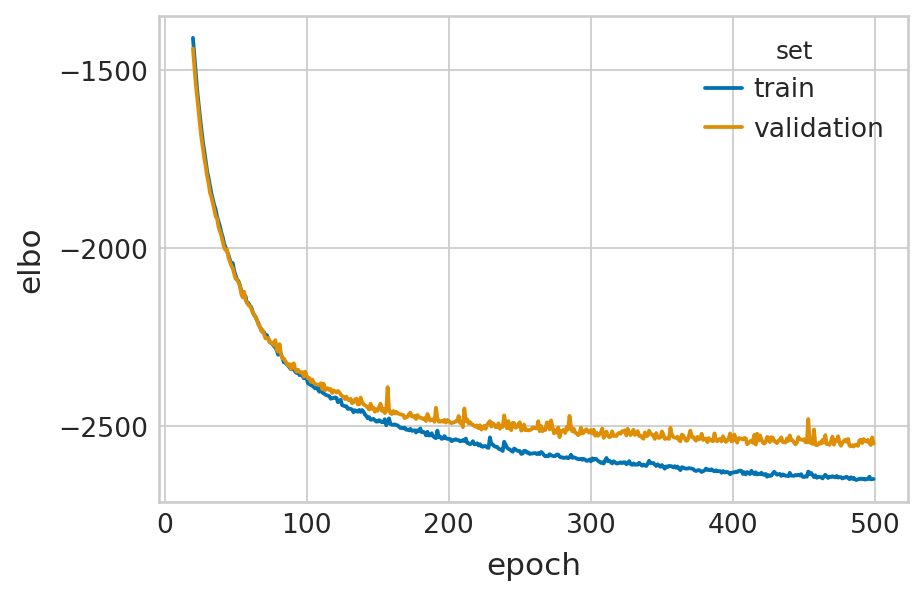

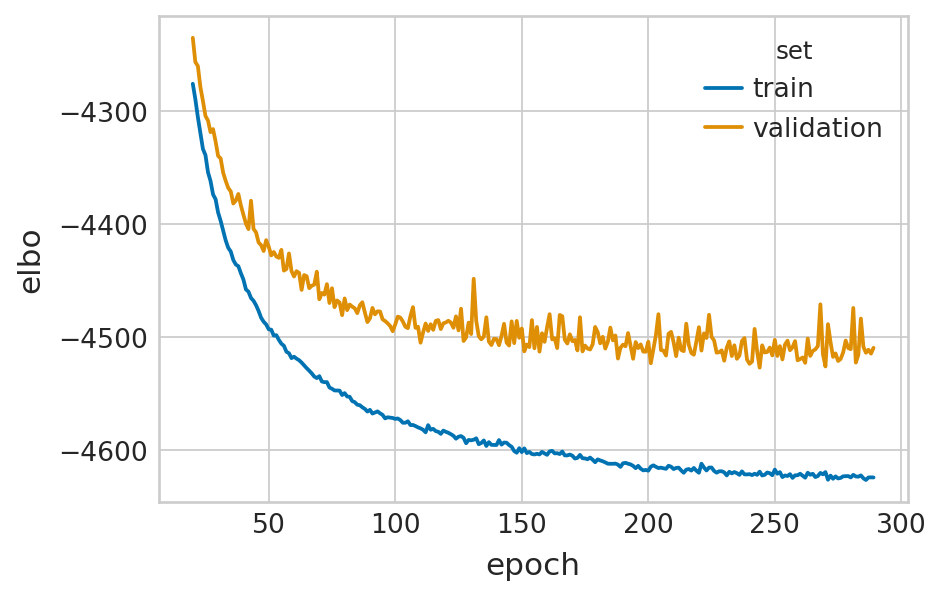

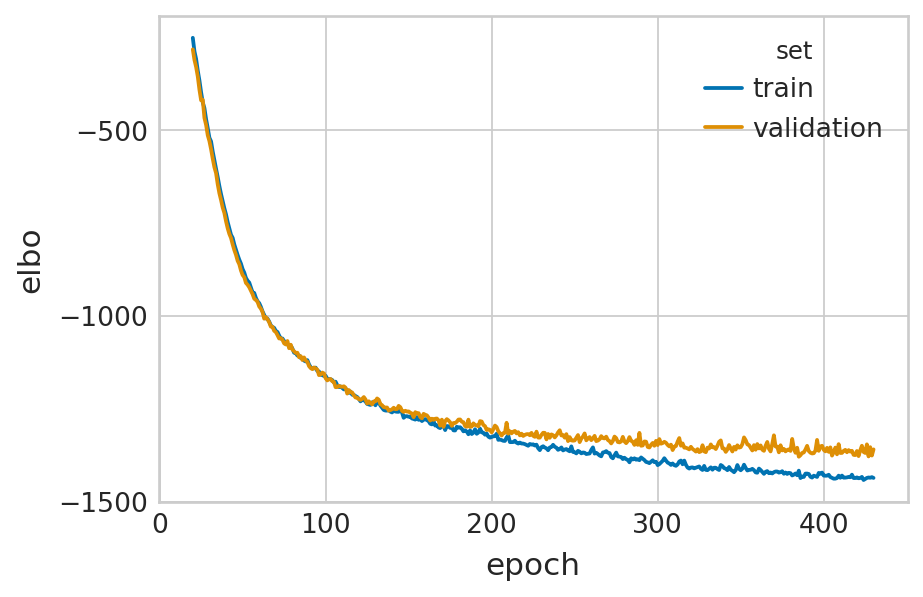

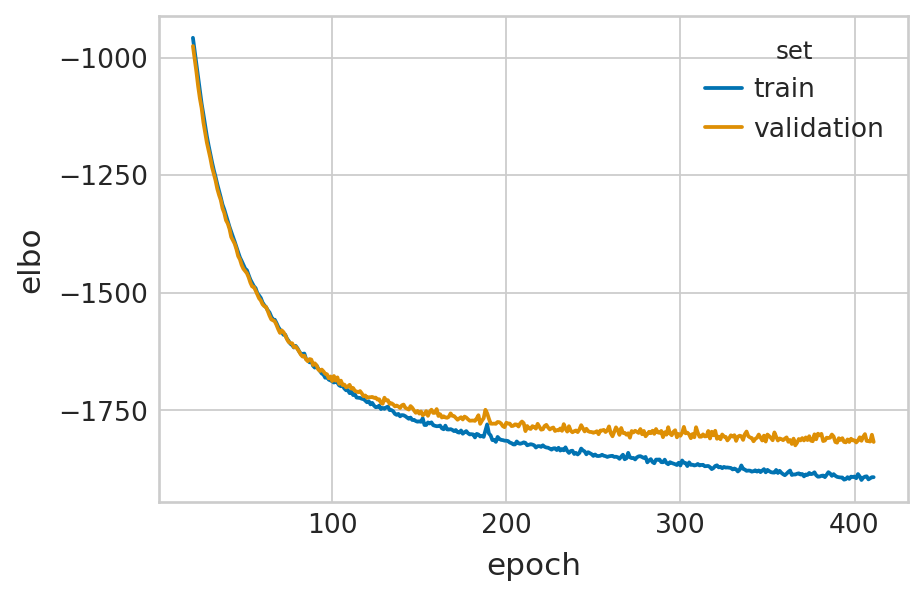

In [15]:
fits_velovi = {}
velovi_vaes = []
for b, n in zip(bdatas, names):
    velovi_vaes.append(fit_velovi(b))
    fits_velovi[n] = get_fit_velovi(b, velovi_vaes[-1])

## Comparison of model fits

### MSE

In [16]:
dfs = []
for a, n in zip(adatas, names):
    ms = a.to_df("Ms")
    mu = a.to_df("Mu")
    mse_df = compute_mse(
        ms,
        mu,
        fits_velovi[n][0],
        fits_velovi[n][1],
        fits_scvelo[n][0],
        fits_scvelo[n][1],
    )
    mse_df["Dataset"] = n
    dfs.append(mse_df)
mse_df = pd.concat(dfs, axis=0)

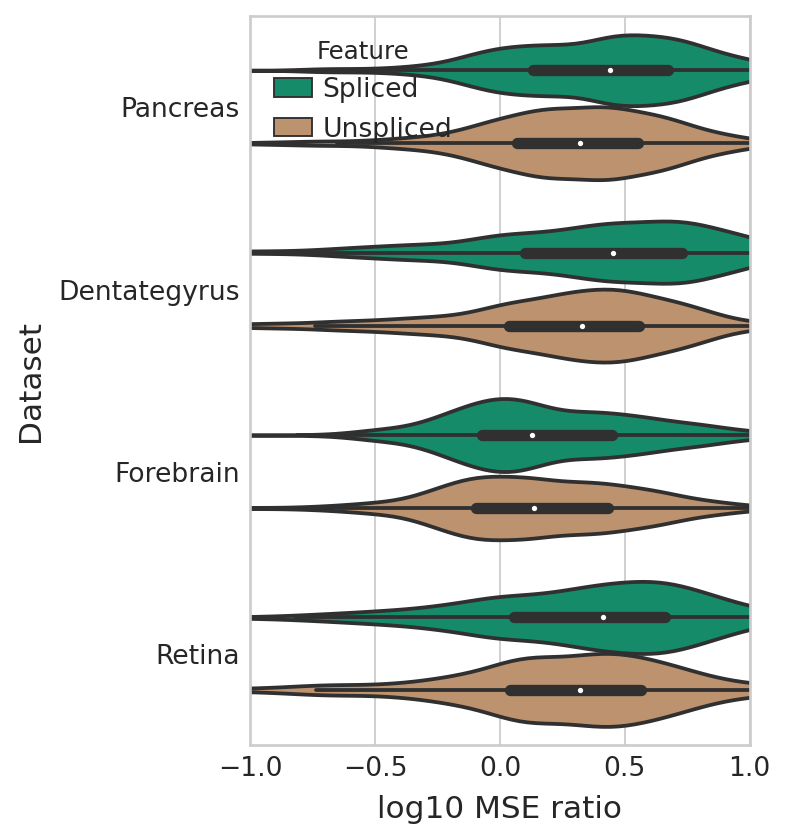

In [17]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(4, 6))
    sns.violinplot(
        data=mse_df,
        orient="h",
        ax=ax,
        y="Dataset",
        x="log10 MSE ratio",
        hue="Feature",
        palette=["#029e73", "#ca9161"],
    );
    

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'mse_unspliced_spliced.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

    ax.set_xlim([-1, 1]);
    fig.savefig(
        FIG_DIR / 'comparison' / 'mse_unspliced_spliced_clipped.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### Confidence

In [18]:
dfs = []
for a, n in zip(adatas, names):
    g_df = compute_confidence(a)
    g_df["Dataset"] = n
    g_df["Method"] = "scVelo"
    dfs.append(g_df)

for a, n in zip(bdatas, names):
    g_df = compute_confidence(a, vkey="velocities_velovi")
    g_df["Dataset"] = n
    g_df["Method"] = "veloVI"
    dfs.append(g_df)

conf_df = pd.concat(dfs, axis=0)

computing velocity graph (using 8/112 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:40) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/1720 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/2726 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:44) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/1720 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)
computing velocity graph (using 8/112 cores)


  0%|          | 0/2726 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)


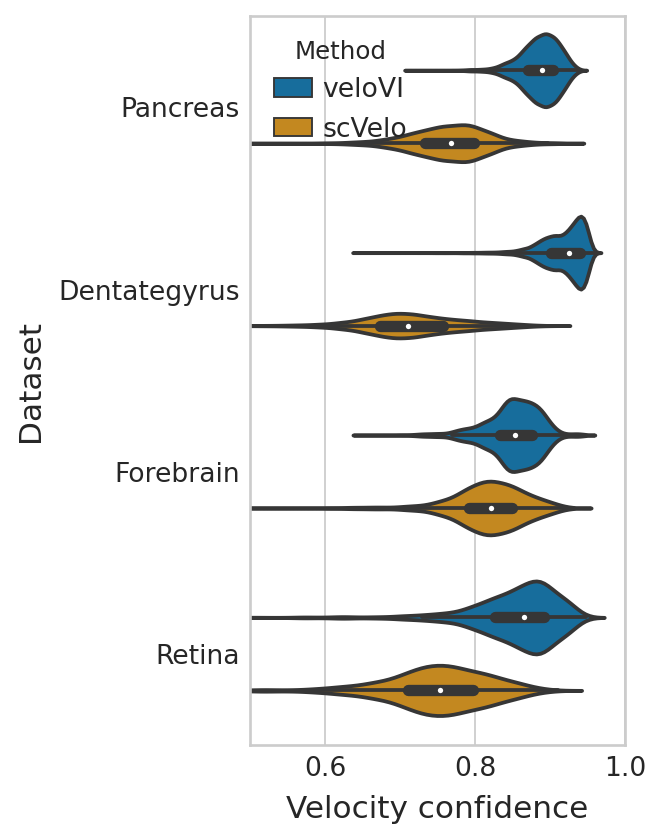

In [19]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.violinplot(
        data=conf_df,
        ax=ax,
        orient="h",
        y="Dataset",
        x="Velocity confidence",
        hue="Method",
        hue_order=["veloVI", "scVelo"],
        palette=sns.color_palette(['#0173B2', '#DE8F05']),
    );
    
if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'velocity_confidence.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )
    
    ax.set_xlim([0.5, 1]);
    fig.savefig(
        FIG_DIR / 'comparison' / 'velocity_confidence_clipped.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### Velocity correlation

In [20]:
correlations = []
name_long = []

for a, b, n in zip(adatas, bdatas, names):
    corr_mat = np.corrcoef(
        a.to_df("velocity"), b.to_df("velocities_velovi"), rowvar=False
    )
    cross_corrs = np.diagonal(corr_mat[a.shape[1] :, : a.shape[1]])
    correlations.append(cross_corrs)
    name_long.append([n] * len(cross_corrs))
velo_corr_df = pd.DataFrame()
velo_corr_df["Pearson correlation"] = np.concatenate(correlations).ravel()
velo_corr_df["Dataset"] = np.concatenate(name_long).ravel()

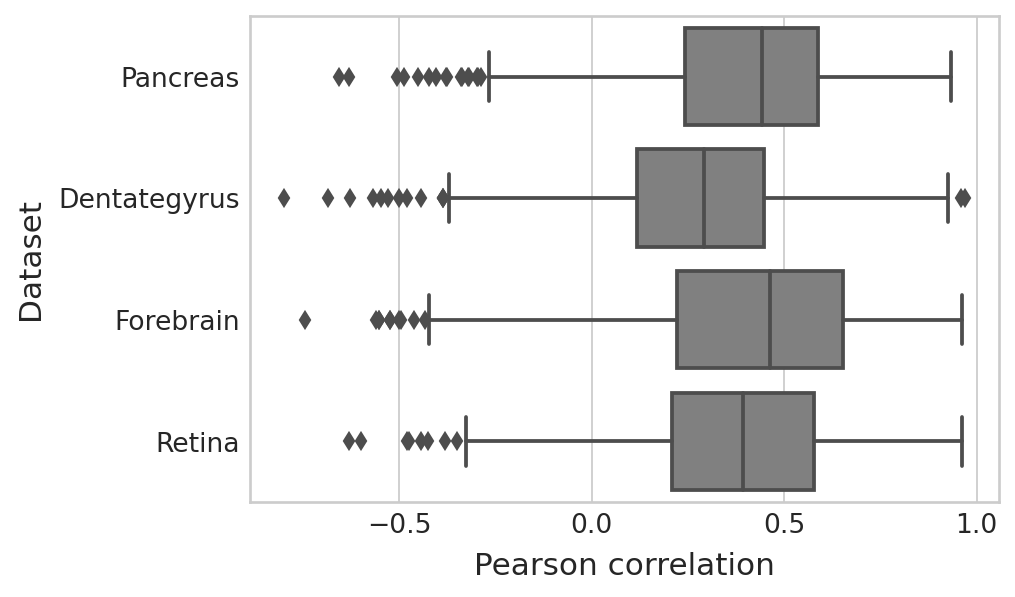

In [21]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(data=velo_corr_df, x="Pearson correlation", y="Dataset", color="grey", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'pearson_correlation_velocity.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### Latent time correlation

In [22]:
correlations = []
name_long = []

for a, b, n in zip(adatas, bdatas, names):
    corr_mat = spearmanr(
        a.to_df("fit_t"), b.to_df("fit_t")
    ).correlation
    cross_corrs = np.diagonal(corr_mat[a.shape[1] :, : a.shape[1]])
    correlations.append(cross_corrs)
    name_long.append([n] * len(cross_corrs))
time_corr_df = pd.DataFrame()
time_corr_df["Spearman correlation"] = np.concatenate(correlations).ravel()
time_corr_df["Dataset"] = np.concatenate(name_long).ravel()

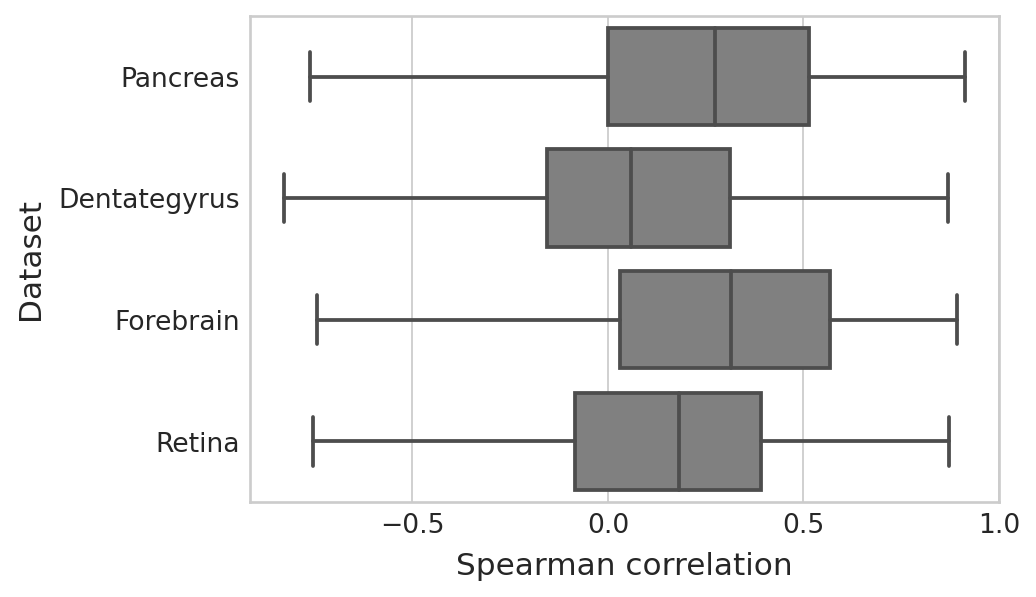

In [23]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(data=time_corr_df, x="Spearman correlation", y="Dataset", color="grey", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'spearman_correlation_cell_gene_time.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )